# 1. Ile-de-France Metro Station Ticket Validation Data by Fare Class

## 1.1 Import dependencies

In [ ]:
import csv
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

## 1.2 Parse the data

### 1.2.1 We begin by importing the number of ticket scans in Paris train stations for the first half of 2023
- Data can be found at https://prim.iledefrance-mobilites.fr/fr/jeux-de-donnees/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre?TSPD_101_R0=08a61e3f76ab2000d3b04e20c78c8eaa398516f7fb6dfae7d2ecfc7aebe2a07be426ea41b2e5f71308d714be171430000fac2a0cb239d29713660c31b5af1aba82337ea6bacb07d7eb0199bace5d9ae291b3df05f6c2e265edd26a5d10977242
- We parse the csv into a nested dict [ridership]: `Map{date : Map{station : {Map{fare : ridership}}}}}`
- to access a certain value, we can use a dict call like `ridership["2023-04-24"]["PORTE MAILLOT"]["student"]`

In [74]:
# Initialize lists for storing keysets of dates, stations, and train types in data
dates = set()
stations = set()
fares = set()

# create dictionary mapping ticket type names to ticket categories
fares_dict = {'NON DEFINI':'normal', 
               'AMETHYSTE':'elderly', 
               'NAVIGO':'normal', 
               'NAVIGO JOUR':'daypass',
               'IMAGINE R':'student',
               'FGT':'subsidized', 
               '?':'normal', 
               'TST':'subsidized',
               'AUTRE TITRE':'normal'}

ticket_scan_csv = "../data/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv"

with open(ticket_scan_csv, 'r') as file:
    reader = csv.reader(file, delimiter=';')
    next(reader)  # Skip header row
    num_rows = 0  
    ridership = {}

    for row in reader:
        # Extract data from the columns
        date = row[0]
        station = row[4]
        fare = fares_dict[row[6]]
        scans = row[7]

        # Append the data to keysets
        dates.add(date)
        stations.add(station)
        fares.add(fare)

        # Append data to dictionary
        if date not in ridership:
            ridership[date] = {}
        if station not in ridership[date]:
            ridership[date][station] = {}
        if fare not in ridership[date][station]:
            ridership[date][station][fare] = int(scans)
        else:
            ridership[date][station][fare] += int(scans)

        # Count the row
        num_rows += 1

print("Parsing " + str(num_rows) + " data points...")
print(f"Successfully parsed:\n {len(dates)} dates\n {len(stations)} stations\n {len(fares)} fare types")
print("\nridership on 2023-04-24:")
print(ridership["2023-04-24"])



Parsing 1096209 data points...
Successfully parsed:
 181 dates
 747 stations
 5 fare types

ridership on 2023-04-24:
{'PORTE MAILLOT': {'normal': 14786, 'student': 3431, 'elderly': 237, 'subsidized': 1448, 'daypass': 81}, 'ALESIA': {'normal': 7222, 'student': 2280, 'subsidized': 883, 'elderly': 340, 'daypass': 28}, 'BOULOGNE-ST.CL': {'elderly': 88, 'normal': 5808, 'subsidized': 418, 'student': 1384, 'daypass': 18}, 'OLYMPIADES': {'elderly': 606, 'subsidized': 1703, 'daypass': 30, 'normal': 11789, 'student': 3589}, 'LES AGNETTES': {'normal': 4202, 'elderly': 188, 'daypass': 5, 'subsidized': 993, 'student': 918}, 'FUNICULAIRE': {'elderly': 140, 'subsidized': 400, 'normal': 1776, 'student': 1581, 'daypass': 249}, 'BREGUET-SABIN': {'normal': 3997, 'elderly': 84, 'subsidized': 454, 'daypass': 14, 'student': 1037}, 'CRETEIL-P. LAC': {'normal': 4695, 'subsidized': 915, 'elderly': 261, 'student': 1538, 'daypass': 7}, 'FR. POPULAIRE': {'student': 1332, 'subsidized': 850, 'normal': 4853, 'daypas

### 1.2.2 Search for missing datapoints

In [75]:
## FIND MISSING DATES
print("CHECKING FOR MISSING DATES:")
start_date = datetime.date(2023, 1, 1)
end_date = datetime.date(2023, 6, 30)
delta = datetime.timedelta(days=1)

missing_dates = False
for day in range((end_date - start_date).days + 1):
    current_date = start_date + delta * day
    current_date_string = current_date.strftime("%Y-%m-%d")

    # Check if the list contains the current date
    if current_date_string not in dates:
        missing_dates = True
        print(f"{current_date_string} is not in the list.")

if not missing_dates:
    print("No missing dates\n")

## FIND MISSING STATIONS ON A GIVEN DAY
print("CHECKING FOR MISSING STATIONS:")
incomplete_stations = {}

missing_stations = False
for date in dates:
    for station in stations:
        if station not in ridership[date]:
            missing_stations = True
            if station in incomplete_stations:
                incomplete_stations[station] += 1
            else:
                incomplete_stations[station] = 1

if missing_stations:
    print(f"{len([station for station, num_missing in incomplete_stations.items() if num_missing > 0])} stations with more than 0 dates missing")
    # print(f"{len([station for station, num_missing in incomplete_stations.items() if num_missing > 1])} stations with more than 1 date missing")
    # print(f"{len([station for station, num_missing in incomplete_stations.items() if num_missing > 2])} stations with more than 2 dates missing")
else:
    print("No missing stations\n")

# for now, remove all stations that have incomplete data on a given day
for date in dates:
    for station in incomplete_stations:
        if station in ridership[date] and incomplete_stations[station] > 0:
            ridership[date].pop(station)
print(f"{len(ridership['2023-01-01'])} stations remaining")

## FIND MISSING FARES ON A GIVEN DAY
print("\nCHECKING FOR MISSING FARES:")
incomplete_fares = {}

missing_fares = False
for date in dates:
    for station in list(ridership[date].keys()):
        if len(ridership[date][station].keys()) < 4: # look for stations missing more than one fare type for a day
            missing_fares = True
            if station not in incomplete_fares:
                incomplete_fares[station] = 1
            else:
                incomplete_fares[station] += 1

# for now, remove all stations that have incomplete data on more than one given day
count = 0
for date in dates:
    for station in incomplete_fares:
        if incomplete_fares[station] > 3: # missing data for more than three days
            ridership[date].pop(station)
print(f"{len([station for station, num_missing in incomplete_fares.items() if num_missing > 1])} stations with more than 1 fare missing for more than 1 date")
print(f"{len(ridership['2023-01-01'])} stations remaining")
    

CHECKING FOR MISSING DATES:
No missing dates

CHECKING FOR MISSING STATIONS:
191 stations with more than 0 dates missing
556 stations remaining

CHECKING FOR MISSING FARES:
174 stations with more than 1 fare missing for more than 1 date
444 stations remaining


## 1.3 Exploring the Data

### 1.3.1 Plot the daily ridership of the Roland Garros Stadium

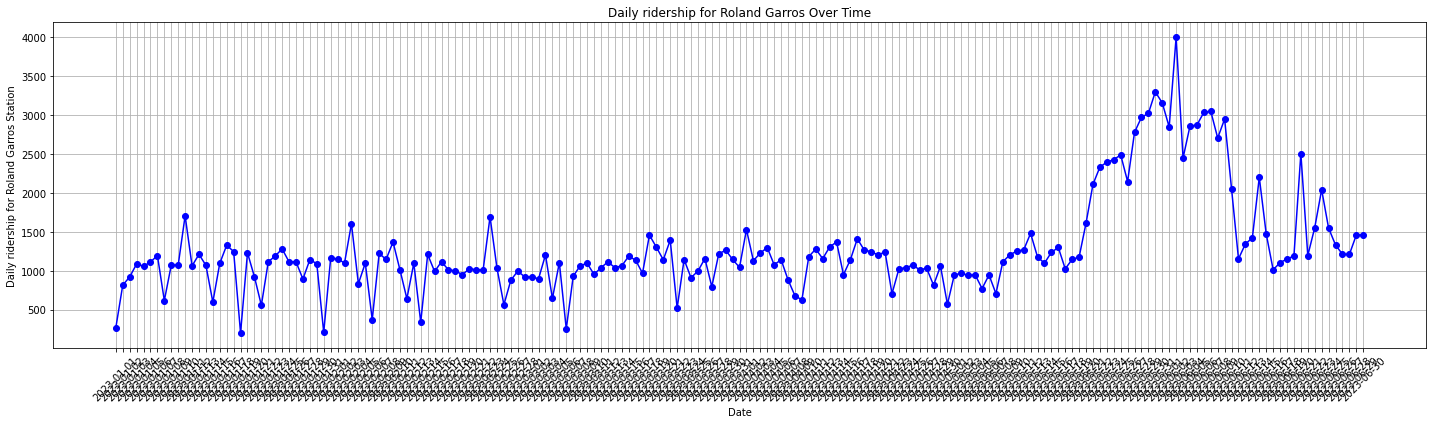

2023-06-03


In [80]:
station_id = "PTE D'AUTEUIL"

# Initialize lists to store dates and sums of fares
xdates = list(ridership.keys())
xdates.sort()
yridership = []

# Loop through the dictionary and calculate the sum of fares for "STADE" station for each date

for date in xdates:
    station_data = ridership[date]
    if station_id in station_data:
        total_fare = sum(station_data[station_id].values())
        yridership.append(total_fare)

# Create the plot
plt.figure(figsize=(20, 6))
plt.plot(xdates, yridership, marker='o', linestyle='-', color='b')
plt.xlabel("Date")
plt.ylabel("Daily ridership for Roland Garros Station")
plt.title("Daily ridership for Roland Garros Over Time")
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Find the index of the maximum value in sum_of_fares
max_ridership = yridership.index(max(yridership))

# Get the corresponding date using the index
max_date = xdates[max_ridership]
print(max_date)

### 1.3.1 Find which stadiums have biggest spikes in ridership on a given day

In [91]:
## first find weekly average ridership for each station
station_daily_ridership = {}

# Iterate through the ridership dictionary and organize data by station and day of the week
for date, station_data in ridership.items():
    for station, data in station_data.items():
        dly_ridership = sum(data.values())
        day_of_week = pd.Timestamp(date).day_name()  # Requires pandas library for day_name() function

        if station not in station_daily_ridership:
            station_daily_ridership[station] = defaultdict(list)
        station_daily_ridership[station][day_of_week].append(dly_ridership)

# Create a dictionary to store the average ridership by day of the week for each station
avg_weekly = {}

# Calculate the average ridership for each station by day of the week
for station, daily_data in station_daily_ridership.items():
    if station not in avg_weekly:
        avg_weekly[station] = {}
    for day, fares in daily_data.items():
        avg_fare = sum(fares) / len(fares) if fares else 0
        avg_weekly[station][day] = avg_fare

print(avg_weekly)

#sort tuple by second element
def sort_tuple(tup):
    tup.sort(key = lambda x: x[1], reverse=True) 
    return tup 

def get_spikes(date):
    # first get day of week
    day_of_week = pd.Timestamp(date).day_name()

    # create a tuple of stadium, ridership spike pairs
    result = []

    station_dict = ridership[date]

    for station, data in station_dict.items():
        result.append((station, sum(data.values()) / avg_weekly[station][day_of_week]))

    sort_tuple(result)
    return result

print(get_spikes("2023-06-03"))


{'SURESNES': {'Sunday': 931.3846153846154, 'Monday': 3685.0384615384614, 'Tuesday': 3947.923076923077, 'Wednesday': 4024.576923076923, 'Thursday': 3990.8846153846152, 'Saturday': 1372.64, 'Friday': 3767.923076923077}, 'TRIEL SUR SEINE': {'Sunday': 293.5769230769231, 'Monday': 620.1538461538462, 'Tuesday': 641.0, 'Wednesday': 653.8076923076923, 'Thursday': 605.1153846153846, 'Saturday': 358.16, 'Friday': 606.2307692307693}, 'VAL D ARGENT': {'Sunday': 3016.0, 'Monday': 6838.7692307692305, 'Tuesday': 7103.884615384615, 'Wednesday': 7373.2692307692305, 'Thursday': 7130.115384615385, 'Saturday': 4306.32, 'Friday': 7702.346153846154}, 'VERSAILLES RD': {'Sunday': 2501.0384615384614, 'Monday': 5173.5, 'Tuesday': 5700.115384615385, 'Wednesday': 5967.2692307692305, 'Thursday': 5622.076923076923, 'Saturday': 3653.8, 'Friday': 5319.7692307692305}, 'BOUGIVAL': {'Sunday': 196.46153846153845, 'Monday': 646.2307692307693, 'Tuesday': 688.8461538461538, 'Wednesday': 699.5769230769231, 'Thursday': 686.84